In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-retail-ii-data-set-from-ml-repository/online_retail_II.xlsx


# **Customer Segmentation with RFM**

# What is RFM?


RFM represents a method used for measuring customer value. An RFM analysis can show you who are the most valuable customers for your business. The ones who buy most frequently, most often, and spend the most. First of all, the metrics you have seen are calculated. 

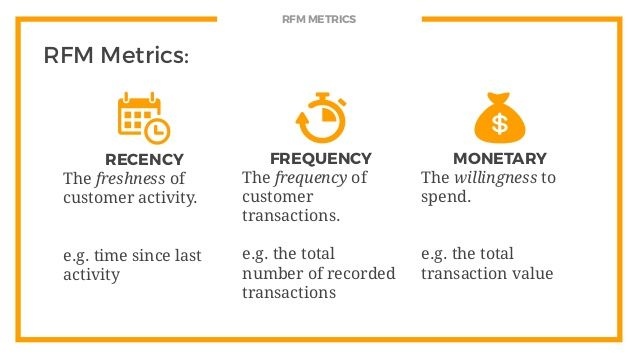

**Recency:** The value that indicates how much time has passed since a customer's last activity or transaction with the brand. The activity is usually a purchase, but sometimes variations are used such as the last visit to a website or the use of a mobile app.

**Frequency:** How often a customer shows in a certain period of activity value. Customers who operate more often may be more loyal than others.

**Monetary:** It is the value that shows how much a customer has spent in a certain period of time. Dividing the value of the spend by frequency shows us the average purchase amount.

# Dataset and Story

An e-commerce company wants to segment its customers and determine marketing strategies according to these segments. The company believes that marketing activities specific to customer segments that exhibit common behaviors will increase revenue. For example, it is desired to organize different campaigns for new customers and different campaigns to retain very profitable customers for the company.

The dataset named Online Retail includes the sales of a UK-based online store between 01/12/2009-09/12/2011. This company's product catalog includes souvenirs. The majority of the company's customers are corporate customers.

**Variables of the data set:**

* InvoiceNo : The number of the invoice, unique per each purchase. Refund invoice numbers contain "C"
* StockCode : Unique code per each item
* Description : Name of the item
* Quantity : The number of items within the invoice
* InvoiceDate : Date and time of the purchase
* UnitPrice : Price of a single item, as of Sterlin
* CustomerID : Unique id number per each customer
* Country : The country where the customer is living

# Load Dataset


In [2]:
!pip install xlrd
!pip install openpyxl
!pip install lifetimes
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

     |████████████████████████████████| 96 kB 2.7 MB/s 
     |████████████████████████████████| 243 kB 4.6 MB/s 
     |████████████████████████████████| 584 kB 4.5 MB/s 


In [3]:
# Read the 2010-2011 data in the OnlineRetail II excel. Make a copy of the data frame you created.

df = pd.read_excel("/kaggle/input/online-retail-ii-data-set-from-ml-repository/online_retail_II.xlsx", sheet_name="Year 2010-2011")
df_copy = df.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom


In [4]:
#Checking Variables

def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(541910, 8)
##################### Types #####################
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object
##################### Head #####################
  Invoice StockCode                         Description  Quantity  \
0  536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
1  536365     71053                 WHITE METAL LANTERN         6   
2  536365    84406B      CREAM CUPID HEARTS COAT HANGER         8   

          InvoiceDate  Price  Customer ID         Country  
0 2010-12-01 08:26:00   2.55     17850.00  United Kingdom  
1 2010-12-01 08:26:00   3.39     17850.00  United Kingdom  
2 2010-12-01 08:26:00   2.75     17850.00  United Kingdom  
##################### Tail #####################
       Invoice Stoc

Check out descriptive statistics of numerical variables. See the difference between 75% and 99% values and then See the difference between 99% and max values. We can think that there are some outliers.

In [5]:
df.describe([0.01,0.25,0.50,0.75,0.99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
Quantity,541910.00,9.55,218.08,-80995.00,-2.00,1.00,3.00,10.00,100.00,80995.00
Price,541910.00,4.61,96.76,-11062.06,0.19,1.25,2.08,4.13,18.00,38970.00
Customer ID,406830.00,15287.68,1713.60,12346.00,12415.00,13953.00,15152.00,16791.00,18212.00,18287.00


<AxesSubplot:>

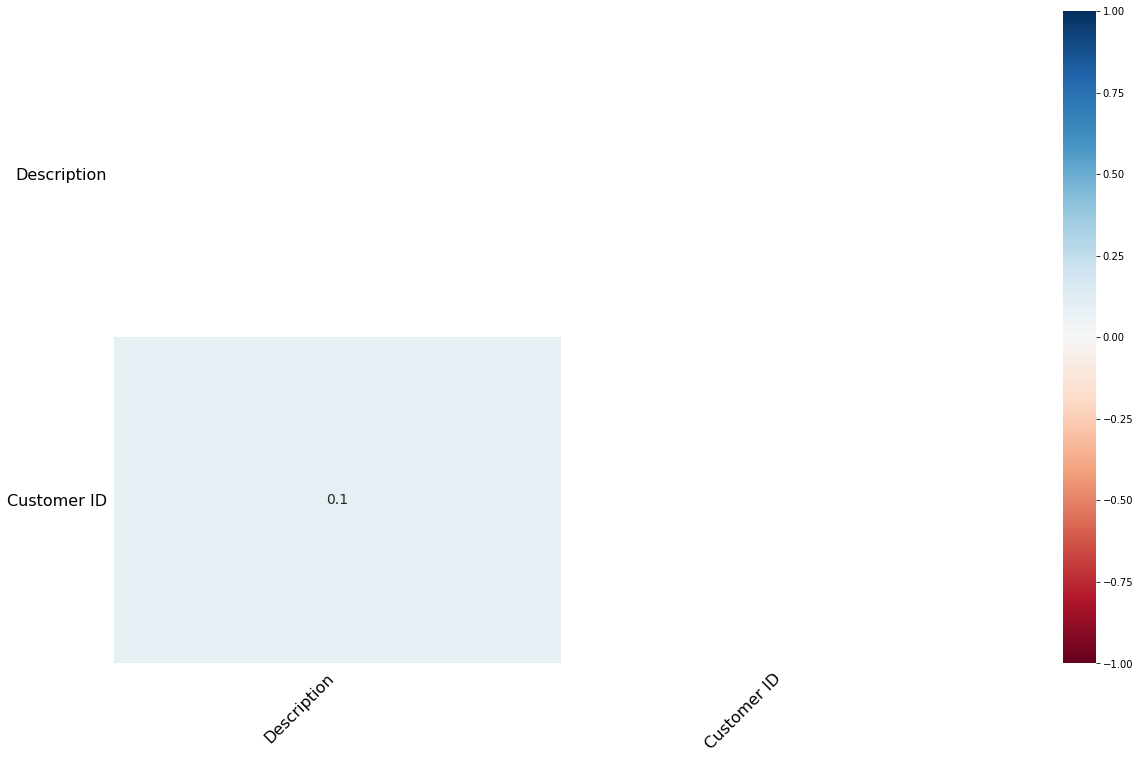

In [6]:
# There is no specific correlation between missing values

msno.heatmap(df)

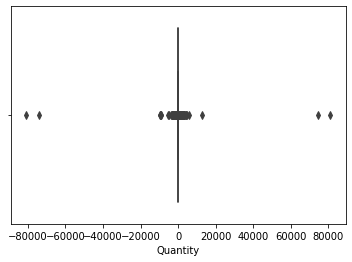

In [7]:
sns.boxplot(df["Quantity"]);

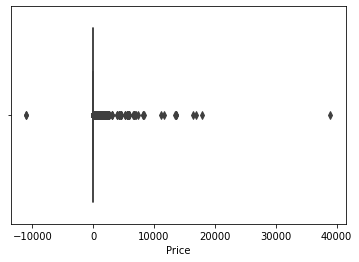

In [8]:
sns.boxplot(df["Price"]);

# Data Preprocessing

Outlier values are trimmed (very little) without damaging the data.Here we have set a lower and upper limit. But since the lower limit is set, we'll only assign it to the upper limit. We'll do it for Quantity and Price.

In [9]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [10]:
replace_with_thresholds(df,"Quantity")
replace_with_thresholds(df,"Price")

In [11]:
# outliers values are now cleaner.

df.describe([0.01,0.25,0.50,0.75,0.99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
Quantity,541910.00,8.52,154.63,-80995.00,-2.00,1.00,3.00,10.00,100.00,253.00
Price,541910.00,3.33,21.65,-11062.06,0.19,1.25,2.08,4.13,18.00,44.71
Customer ID,406830.00,15287.68,1713.60,12346.00,12415.00,13953.00,15152.00,16791.00,18212.00,18287.00


Missing values are deleted. Canceled Invoices are not received and and a new variable was created.

In [12]:
def data_prep(dataframe):
    dataframe.dropna(axis=0, inplace=True)
    dataframe = dataframe[~dataframe["Invoice"].str.contains("C", na=False)]
    dataframe = dataframe[dataframe["Quantity"] > 0]
    dataframe["TotalPrice"] = dataframe["Quantity"] * dataframe["Price"]
    return dataframe

In [13]:
df= data_prep(df)
check_df(df)

##################### Shape #####################
(397925, 9)
##################### Types #####################
Invoice                object
StockCode              object
Description            object
Quantity              float64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
TotalPrice            float64
dtype: object
##################### Head #####################
  Invoice StockCode                         Description  Quantity  \
0  536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER      6.00   
1  536365     71053                 WHITE METAL LANTERN      6.00   
2  536365    84406B      CREAM CUPID HEARTS COAT HANGER      8.00   

          InvoiceDate  Price  Customer ID         Country  TotalPrice  
0 2010-12-01 08:26:00   2.55     17850.00  United Kingdom       15.30  
1 2010-12-01 08:26:00   3.39     17850.00  United Kingdom       20.34  
2 2010-12-01 08:26:00   2.75     17850.00  United Kingdom     

Variables are as follows after they are cleared of outliers values.

<AxesSubplot:xlabel='Quantity'>

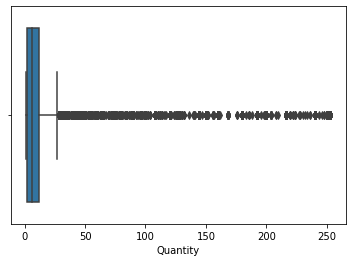

In [14]:
sns.boxplot(df["Quantity"])

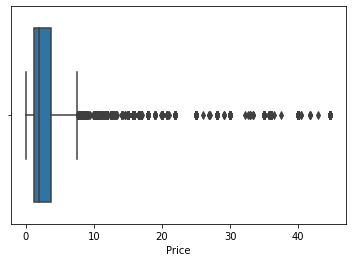

In [15]:
sns.boxplot(df["Price"]);

# Creating RFM Metrics & Calculating RFM Scores

In [16]:
df["InvoiceDate"].max()
today_date = dt.datetime(2011, 12, 11)

# recency
# frequency
# monetary

rfm = df.groupby("Customer ID").agg({"InvoiceDate": lambda x: (today_date - x.max()).days,
                               "Invoice": lambda x: x.nunique(),
                               "TotalPrice": lambda x: x.sum()})

rfm.columns = ["recency", "frequency", "monetary"]

rfm = rfm[rfm["monetary"] > 0]
rfm.head()

,recency,frequency,monetary
Customer ID,,,
12346.00,326,1,263.12
12347.00,3,7,4310.00
12348.00,76,4,1797.24
12349.00,19,1,1502.27
12350.00,311,1,334.40


We segmented our RFM values with the qcut () function. The high recency value means that the customer gets away from us. For this reason, we made the labels decreasing in order to avoid confusion.

In [17]:
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])

rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])


In order to see the RFM values together, we defined a variable named "RFM_SCORE" and combined the RFM values by converting them to strings. If we tried to combine without converting, we might get an error because it would not combine the two categorical variables. (We do not include monetary_score)

In [18]:
rfm["RFM_SCORE"] = (rfm['recency_score'].astype(str) +
                    rfm['frequency_score'].astype(str))

# Naming & Analysing RFM Segments

In [19]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}


rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)

rfm[["segment", "recency", "frequency", "monetary"]].groupby("segment").agg(["mean", "count"])


recency       frequency       monetary      
                       mean count      mean count     mean count
segment                                                         
about_to_sleep        53.31   352      1.16   352   469.34   352
at_Risk              153.79   593      2.88   593   935.39   593
cant_loose           132.97    63      8.38    63  2633.72    63
champions              6.36   633     12.42   633  6417.60   633
hibernating          217.61  1071      1.10  1071   398.00  1071
loyal_customers       33.61   819      6.48   819  2740.82   819
need_attention        52.43   187      2.33   187   848.09   187
new_customers          7.43    42      1.00    42   312.70    42
potential_loyalists   17.40   484      2.01   484   673.42   484
promising             23.51    94      1.00    94   286.38    94

Then segments are created.

**So why are we doing this?**

We look for answers to these questions;

-Who is our most profitable customer? -What is it they appreciate in my products or services? -Who are my new customers? -How do I attract new customers to the company?

The answers to the questions are hidden in the segmentation.

With better RFM segmentation, we’ll be able to address certain segments in a personalized manner, based on their needs and preferences.

Browse the scheme to more easily understand segmentation.

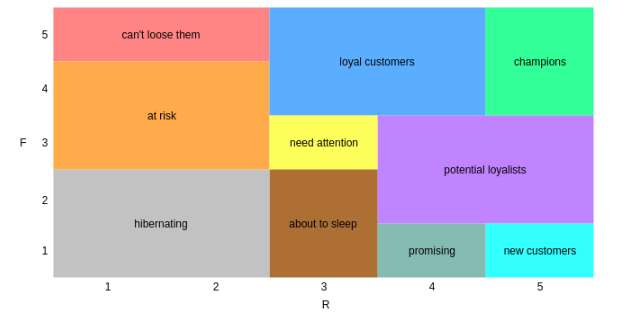

<AxesSubplot:xlabel='segment', ylabel='frequency'>

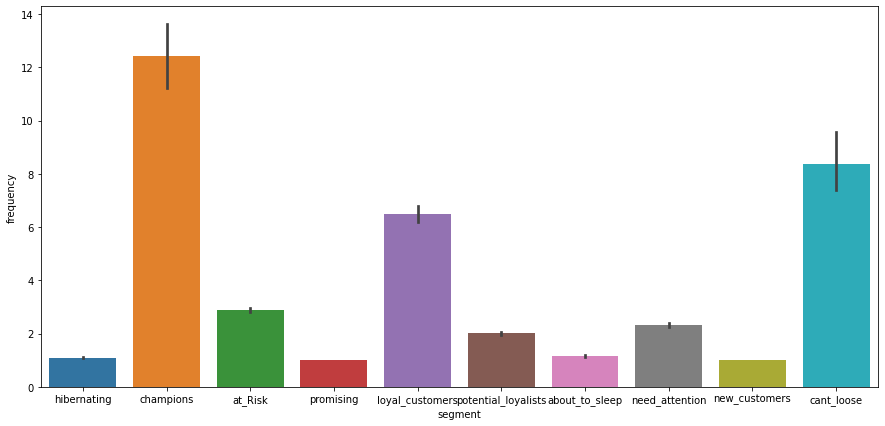

In [20]:
plt.figure(figsize=(15,7))
sns.barplot(x="segment", y="frequency", data=rfm)

Now we can see the customer segments that we want to focus on. For the customer segment that they want to focus on, a marketing strategy can be chosen easily.

In [21]:
# Select the customer IDs of the Loyal Customers class and get the excel output.

rfm[rfm["segment"] == "loyal_customers"]

new_df = pd.DataFrame()
new_df["new_customer_id"] = rfm[rfm["segment"] == "loyal_customers"].index
new_df.head()

,new_customer_id
0,12352.00
1,12359.00
2,12370.00
3,12380.00
4,12388.00


In [22]:
new_df.to_excel("loyal_customers.xlsx")